In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv("wine-reviews.csv", usecols=["country", "description", "points", "price", "variety", "winery"])

In [3]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [4]:
df = df.dropna(subset=["description", "points"])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


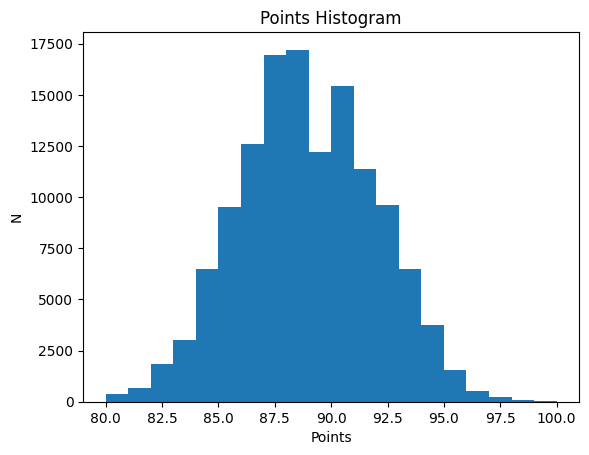

In [6]:
plt.hist(df.points, bins=20)
plt.title("Points Histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [7]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [8]:
df.head()

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0


In [9]:
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

d:\Python\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
len(train), len(val), len(test)

(103976, 12997, 12998)

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
    df = dataframe.copy()
    labels = df.pop('label')
    df = df["description"]
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [12]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

### Embedding + Model

Machines are not good at understanding english words so we convert words into stream of numbers

In [13]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [14]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.26883274, -0.06979506, -0.030349  , ..., -0.12783247,
        -0.3387572 ,  0.2696439 ],
       [ 0.10094484, -0.12149406, -0.00220958, ..., -0.07169528,
        -0.28020215, -0.09668855],
       [ 0.29042843, -0.18347652, -0.20212886, ...,  0.11712003,
         0.05443046, -0.06648985],
       ...,
       [ 0.33829913, -0.3154023 , -0.14873584, ...,  0.06269286,
        -0.16494831, -0.21078777],
       [ 0.1350519 , -0.0647922 , -0.05884589, ..., -0.3754451 ,
        -0.1733586 , -0.09851064],
       [ 0.23139276, -0.37484673, -0.2105042 , ..., -0.12876743,
         0.12735173, -0.04368521]], dtype=float32)>

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Lambda(lambda x:hub_layer(x)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [17]:
history = model.fit(train_data, epochs=10,validation_data=valid_data)

Epoch 1/10



102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5975 - loss: 0.6726 - val_accuracy: 0.6306 - val_loss: 0.6385
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6371 - loss: 0.6420 - val_accuracy: 0.6645 - val_loss: 0.6118
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6554 - loss: 0.6206 - val_accuracy: 0.6777 - val_loss: 0.5995
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6665 - loss: 0.6103 - val_accuracy: 0.6821 - val_loss: 0.5911
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6731 - loss: 0.6029 - val_accuracy: 0.6835 - val_loss: 0.5866
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6799 - loss: 0.5954 - val_accuracy: 0.6875 - val_loss: 0.5848
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6798 - loss: 0.5970 - val_accuracy: 0.6891 - val_loss: 0.5823
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6871 - loss: 0.5910 - val_accuracy: 0.691

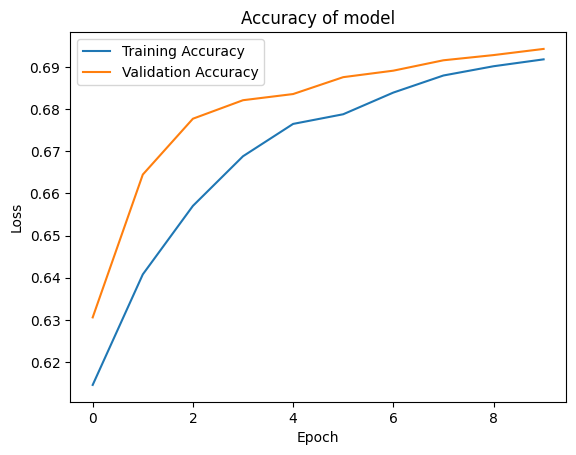

In [18]:
plt.plot(history.history['accuracy'], label="Training Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title("Accuracy of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

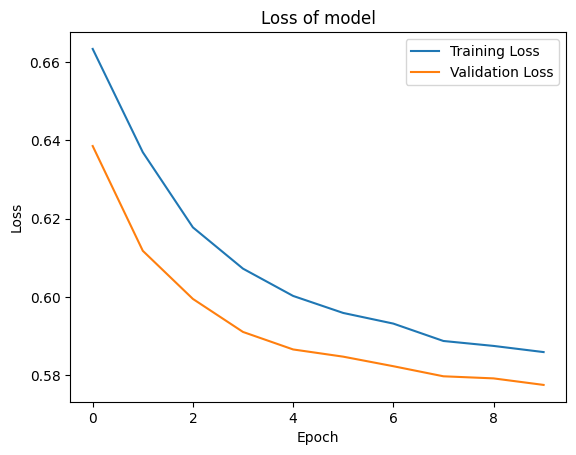

In [19]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [20]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7080 - loss: 0.5655


[0.5650626420974731, 0.7094168066978455]

### LSTM
Instead of using downloaded Embedding, creating custom Embedding

In [21]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label:text))

In [22]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32), #since output dimension (output_dim) is 32
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [25]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 29s 239ms/step - accuracy: 0.6608 - loss: 0.6165 - val_accuracy: 0.8229 - val_loss: 0.3864
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - accuracy: 0.8357 - loss: 0.3723 - val_accuracy: 0.8322 - val_loss: 0.3642
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - accuracy: 0.8464 - loss: 0.3501 - val_accuracy: 0.8343 - val_loss: 0.3584
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - accuracy: 0.8483 - loss: 0.3425 - val_accuracy: 0.8349 - val_loss: 0.3578
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.8526 - loss: 0.3351 - val_accuracy: 0.8322 - val_loss: 0.3617


In [26]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.8406 - loss: 0.3513


[0.3472711741924286, 0.8434374332427979]